In [ ]:
!pip install pandas scikit-learn numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.1/676.1 kB 15.6 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import logging
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
import pickle
import os
import seaborn as sns

# Configure logging
logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

In [ ]:
vectorizer = None
model = None
label_encoder = LabelEncoder()
# Default threshold is 0.5, can be adjusted
spam_threshold = 0.5

In [ ]:
# Clean and preprocess text function
def prepare_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Load and prepare dataset
dataset_path = "dataset.csv"  # Replace with your actual dataset path
df = pd.read_csv(dataset_path)

# Ensure we have required columns
if 'text' not in df.columns or 'text_type' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'text_type' columns")

# Preprocess text messages
df['cleaned_text'] = df['text'].apply(prepare_text)

# Convert labels (ham/spam) to numerical values
df['text_type'] = df['text_type'].str.lower()  # Convert labels to lowercase
if not all(df['text_type'].isin(['ham', 'spam'])):
    raise ValueError("Labels must be either 'ham' or 'spam'")

# Encode labels
y = label_encoder.fit_transform(df['text_type'])

In [ ]:
# Create TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Train Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Get predictions with probabilities
y_pred_proba = model.predict_proba(X_test)

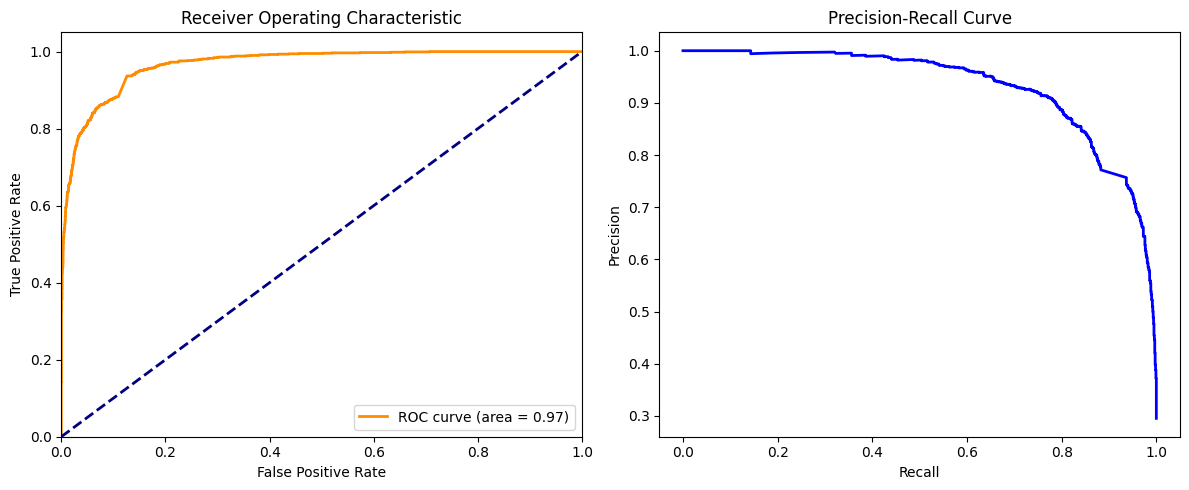

Evaluation curves saved to 'model_evaluation_curves.png'


In [ ]:
# Plot ROC curve and Precision-Recall curve
# Identify which column corresponds to spam
spam_index = np.where(label_encoder.classes_ == 'spam')[0][0]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba[:, spam_index],
                               pos_label=spam_index)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(
    y_test, y_pred_proba[:, spam_index], pos_label=spam_index)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()

# Save plot to file
plt.savefig('model_evaluation_curves.png')
plt.show()

print("Evaluation curves saved to 'model_evaluation_curves.png'")

In [ ]:
# Find optimal threshold based on F1 score
# Get precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(
    y_test, y_pred_proba[:, spam_index], pos_label=spam_index)

# Calculate F1 score for each threshold
# Add a small epsilon to avoid division by zero
epsilon = 1e-7
f1_scores = 2 * precision * recall / (precision + recall + epsilon)

# Find threshold that maximizes F1 score
# Note: precision_recall_curve returns one more element in precision and recall
# than thresholds, so we use only the relevant part
best_threshold_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_threshold_idx]

# Adjust threshold to favor spam detection if needed
# Increase this bias value to be more aggressive in spam detection
bias = 0.05
spam_threshold = max(0.0, min(1.0, best_threshold - bias))

print(f"\nOptimal threshold from F1 score: {best_threshold:.3f}")
print(f"Adjusted threshold with bias: {spam_threshold:.3f}")


Optimal threshold from F1 score: 0.419
Adjusted threshold with bias: 0.369


In [ ]:
# Evaluate model with optimized threshold
# Convert probabilities to predictions using the optimized threshold
y_pred_optimized = (y_pred_proba[:, spam_index] >= spam_threshold).astype(int)

print("\nModel Performance with Optimized Threshold:")
print(classification_report(
    y_test,
    y_pred_optimized,
    target_names=label_encoder.classes_
))

# Print confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_optimized)
print(cm)

# Interpret confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Ham correctly identified): {tn}")
print(f"False Positives (Ham incorrectly flagged as spam): {fp}")
print(f"False Negatives (Spam missed): {fn}")
print(f"True Positives (Spam correctly identified): {tp}")

# Print class distribution
print("\nClass Distribution in Training Data:")
train_dist = pd.Series(y_train).value_counts().to_dict()
for label, count in train_dist.items():
    class_name = label_encoder.inverse_transform([label])[0]
    print(f"{class_name}: {count} messages")


Model Performance with Optimized Threshold:
              precision    recall  f1-score   support

         ham       0.94      0.92      0.93      2868
        spam       0.82      0.86      0.84      1202

    accuracy                           0.91      4070
   macro avg       0.88      0.89      0.89      4070
weighted avg       0.91      0.91      0.91      4070


Confusion Matrix:
[[2648  220]
 [ 165 1037]]
True Negatives (Ham correctly identified): 2648
False Positives (Ham incorrectly flagged as spam): 220
False Negatives (Spam missed): 165
True Positives (Spam correctly identified): 1037

Class Distribution in Training Data:
ham: 11469 messages
spam: 4809 messages



Confusion Matrix:
[[2648  220]
 [ 165 1037]]
True Negatives (Ham correctly identified): 2648
False Positives (Ham incorrectly flagged as spam): 220
False Negatives (Spam missed): 165
True Positives (Spam correctly identified): 1037


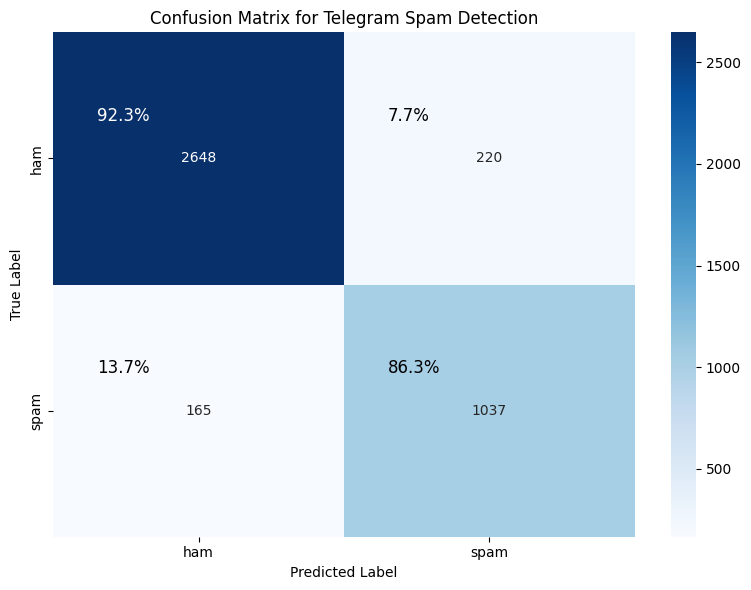

In [ ]:
# After generating the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_optimized)
print(cm)

# Interpret confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Ham correctly identified): {tn}")
print(f"False Positives (Ham incorrectly flagged as spam): {fp}")
print(f"False Negatives (Spam missed): {fn}")
print(f"True Positives (Spam correctly identified): {tp}")

# Add this new code for visualization
# Visualize confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

# Add labels and title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Telegram Spam Detection')

# Add text annotations for percentages
total_ham = cm[0, 0] + cm[0, 1]
total_spam = cm[1, 0] + cm[1, 1]

plt.text(0.15, 0.35, f'{100 * cm[0, 0] / total_ham:.1f}%', fontsize=12, color='white')
plt.text(1.15, 0.35, f'{100 * cm[0, 1] / total_ham:.1f}%', fontsize=12, color='black')
plt.text(0.15, 1.35, f'{100 * cm[1, 0] / total_spam:.1f}%', fontsize=12, color='black')
plt.text(1.15, 1.35, f'{100 * cm[1, 1] / total_spam:.1f}%', fontsize=12, color='black')

plt.tight_layout()
plt.savefig('confusion_matrix_heatmap.png', dpi=300)
plt.show()

In [ ]:
# Print top features that indicate spam and ham
top_n = 10  # Number of top features to display

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get spam and ham indices
spam_index = np.where(label_encoder.classes_ == 'spam')[0][0]
ham_index = np.where(label_encoder.classes_ == 'ham')[0][0]

# Get log probabilities
spam_log_probs = model.feature_log_prob_[spam_index]
ham_log_probs = model.feature_log_prob_[ham_index]

# Calculate difference: positive means more likely in spam
log_prob_diff = spam_log_probs - ham_log_probs

# Get indices of top spam indicators (highest positive difference)
top_spam_indices = np.argsort(log_prob_diff)[-top_n:][::-1]

# Get indices of top ham indicators (lowest negative difference)
top_ham_indices = np.argsort(log_prob_diff)[:top_n]

print("\nTop Spam Indicator Words:")
for idx in top_spam_indices:
    word = feature_names[idx]
    print(f"  - {word} (Log probability ratio: {log_prob_diff[idx]:.3f})")

print("\nTop Ham Indicator Words:")
for idx in top_ham_indices:
    word = feature_names[idx]
    print(f"  - {word} (Log probability ratio: {log_prob_diff[idx]:.3f})")


Top Spam Indicator Words:
  - noida (Log probability ratio: 3.912)
  - rs (Log probability ratio: 3.792)
  - bhk (Log probability ratio: 3.770)
  - earn (Log probability ratio: 3.692)
  - lac (Log probability ratio: 3.646)
  - earning (Log probability ratio: 3.596)
  - guaranteed (Log probability ratio: 3.591)
  - hyperlink (Log probability ratio: 3.558)
  - viagra (Log probability ratio: 3.541)
  - investing (Log probability ratio: 3.510)

Top Ham Indicator Words:
  - ect (Log probability ratio: -4.852)
  - enron (Log probability ratio: -4.733)
  - vince (Log probability ratio: -4.710)
  - kaminski (Log probability ratio: -4.148)
  - hou (Log probability ratio: -4.066)
  - ltgt (Log probability ratio: -3.319)
  - shirley (Log probability ratio: -3.198)
  - stinson (Log probability ratio: -3.097)
  - lor (Log probability ratio: -3.053)
  - crenshaw (Log probability ratio: -3.020)



Top Spam Indicator Words:
  - noida (Log probability ratio: 3.912)
  - rs (Log probability ratio: 3.792)
  - bhk (Log probability ratio: 3.770)
  - earn (Log probability ratio: 3.692)
  - lac (Log probability ratio: 3.646)
  - earning (Log probability ratio: 3.596)
  - guaranteed (Log probability ratio: 3.591)
  - hyperlink (Log probability ratio: 3.558)
  - viagra (Log probability ratio: 3.541)
  - investing (Log probability ratio: 3.510)

Top Ham Indicator Words:
  - ect (Log probability ratio: -4.852)
  - enron (Log probability ratio: -4.733)
  - vince (Log probability ratio: -4.710)
  - kaminski (Log probability ratio: -4.148)
  - hou (Log probability ratio: -4.066)
  - ltgt (Log probability ratio: -3.319)
  - shirley (Log probability ratio: -3.198)
  - stinson (Log probability ratio: -3.097)
  - lor (Log probability ratio: -3.053)
  - crenshaw (Log probability ratio: -3.020)


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1781: RuntimeWarning: coroutine 'Application.shutdown' was never awaited
  to_canonical = {alias: canonical
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1781: RuntimeWarning: coroutine 'Application._bootstrap_initialize' was never awaited
  to_canonical = {alias: canonical


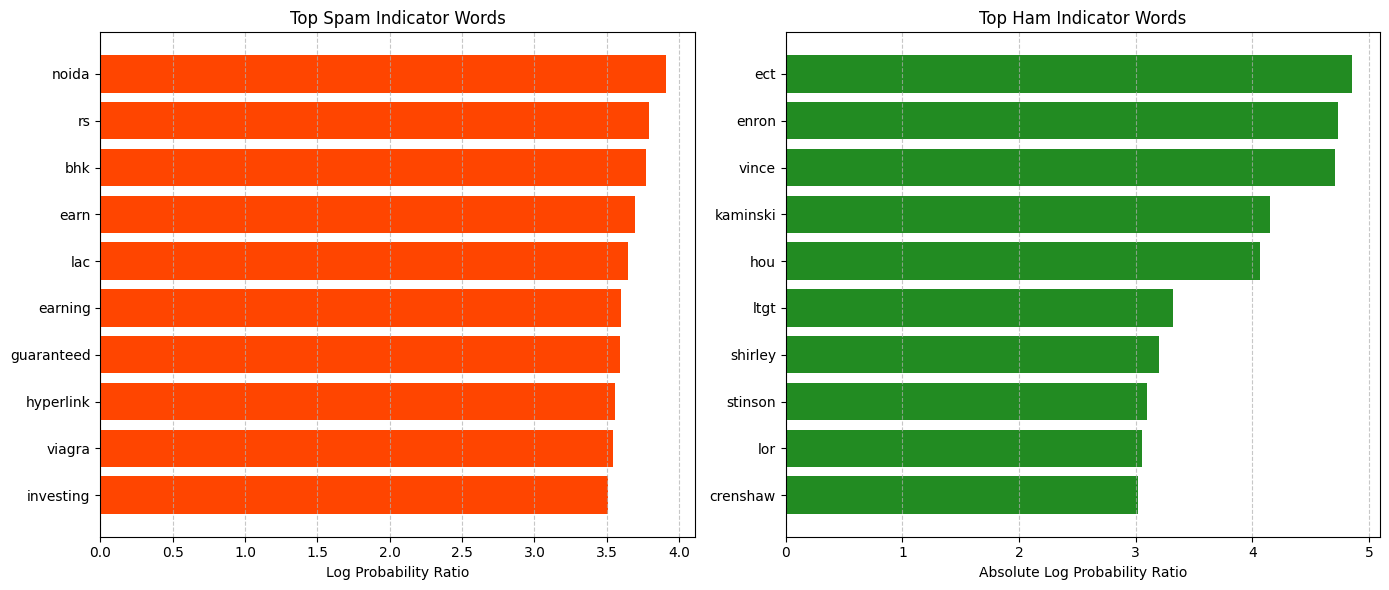

In [ ]:
# After printing top features
print("\nTop Spam Indicator Words:")
top_spam_words = []
top_spam_values = []
for idx in top_spam_indices:
    word = feature_names[idx]
    value = log_prob_diff[idx]
    top_spam_words.append(word)
    top_spam_values.append(value)
    print(f"  - {word} (Log probability ratio: {value:.3f})")

print("\nTop Ham Indicator Words:")
top_ham_words = []
top_ham_values = []
for idx in top_ham_indices:
    word = feature_names[idx]
    value = log_prob_diff[idx]
    top_ham_words.append(word)
    top_ham_values.append(value)
    print(f"  - {word} (Log probability ratio: {value:.3f})")

# Add this new code for visualization
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot spam features
ax1.barh(top_spam_words, top_spam_values, color='orangered')
ax1.set_xlabel('Log Probability Ratio')
ax1.set_title('Top Spam Indicator Words')
ax1.invert_yaxis()  # Highest value at top
ax1.grid(axis='x', linestyle='--', alpha=0.7)

# Plot ham features
ax2.barh(top_ham_words, [abs(x) for x in top_ham_values], color='forestgreen')
ax2.set_xlabel('Absolute Log Probability Ratio')
ax2.set_title('Top Ham Indicator Words')
ax2.invert_yaxis()  # Highest value at top
ax2.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

In [ ]:
# Save trained model, vectorizer, and label encoder
with open('spam_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
# Save threshold
with open('threshold.pkl', 'wb') as f:
    pickle.dump(spam_threshold, f)

print("Model, vectorizer, label encoder, and threshold saved to files.")

Model, vectorizer, label encoder, and threshold saved to files.


In [ ]:
# Test the model on example messages
test_messages = [
    "Hey, how are you doing today?",
    "URGENT: You have won $1,000,000! Click here to claim NOW!",
    "Meeting scheduled for tomorrow at 10am",
    "FREE IPHONE for you! Limited time offer!"
]

# Create a function to predict spam
def predict_message(text):
    # Preprocess text
    cleaned_text = prepare_text(text)
    # Transform text using vectorizer
    text_vector = vectorizer.transform([cleaned_text])
    # Get probability
    probability = model.predict_proba(text_vector)[0]

    # Get spam index
    spam_index = np.where(label_encoder.classes_ == 'spam')[0][0]

    # Use custom threshold
    is_spam = probability[spam_index] >= spam_threshold

    # Convert prediction to label
    predicted_label = 'spam' if is_spam else 'ham'

    return {
        'message': text,
        'prediction': predicted_label,
        'spam_probability': probability[spam_index]
    }

# Test each message
results = []
for msg in test_messages:
    results.append(predict_message(msg))

# Display results as DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                                             message prediction  \
0                      Hey, how are you doing today?        ham   
1  URGENT: You have won $1,000,000! Click here to...       spam   
2             Meeting scheduled for tomorrow at 10am        ham   
3           FREE IPHONE for you! Limited time offer!       spam   

   spam_probability  
0          0.136933  
1          0.947045  
2          0.013303  
3          0.771734  


                                             message prediction  \
0                      Hey, how are you doing today?        ham   
1  URGENT: You have won $1,000,000! Click here to...       spam   
2             Meeting scheduled for tomorrow at 10am        ham   
3           FREE IPHONE for you! Limited time offer!       spam   

   spam_probability  
0          0.136933  
1          0.947045  
2          0.013303  
3          0.771734  


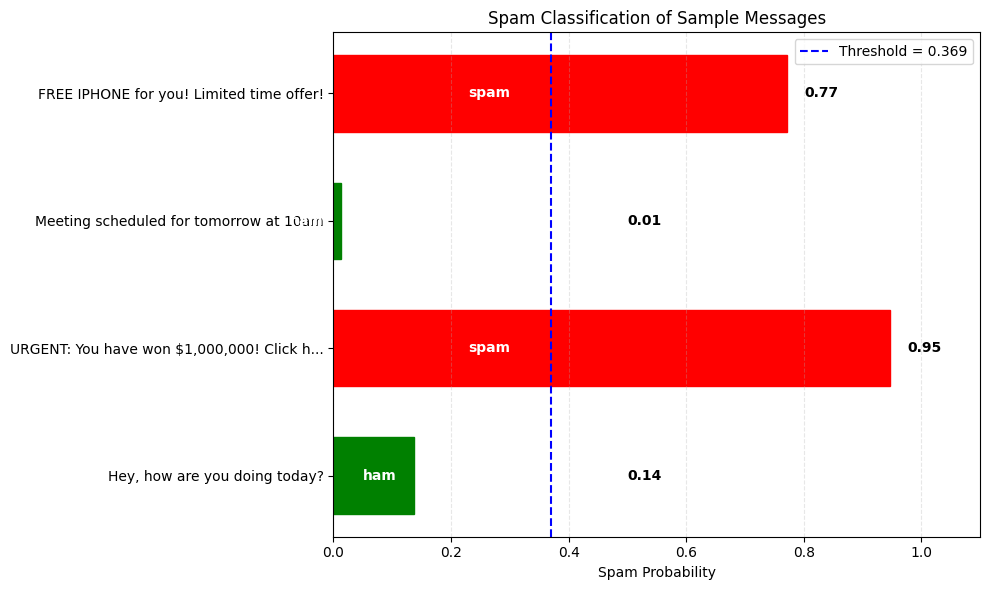

In [ ]:
# After testing on sample messages
# Test the model on example messages
test_messages = [
    "Hey, how are you doing today?",
    "URGENT: You have won $1,000,000! Click here to claim NOW!",
    "Meeting scheduled for tomorrow at 10am",
    "FREE IPHONE for you! Limited time offer!"
]

# Create a function to predict spam
def predict_message(text):
    # Preprocess text
    cleaned_text = prepare_text(text)
    # Transform text using vectorizer
    text_vector = vectorizer.transform([cleaned_text])
    # Get probability
    probability = model.predict_proba(text_vector)[0]

    # Get spam index
    spam_index = np.where(label_encoder.classes_ == 'spam')[0][0]

    # Use custom threshold
    is_spam = probability[spam_index] >= spam_threshold

    # Convert prediction to label
    predicted_label = 'spam' if is_spam else 'ham'

    return {
        'message': text,
        'prediction': predicted_label,
        'spam_probability': probability[spam_index]
    }

# Test each message
results = []
for msg in test_messages:
    results.append(predict_message(msg))

# Display results as DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Add this new code for visualization
# Extract results for visualization
messages = test_messages
spam_probabilities = results_df['spam_probability'].values
predictions = results_df['prediction'].values

# Create figure
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(messages))
bars = plt.barh(y_pos, spam_probabilities, height=0.6)

# Color the bars based on classification
for i, bar in enumerate(bars):
    if predictions[i] == 'spam':
        bar.set_color('red')
    else:
        bar.set_color('green')

# Add threshold line
plt.axvline(x=spam_threshold, color='blue', linestyle='--',
           label=f'Threshold = {spam_threshold:.3f}')

# Add labels and title
plt.yticks(y_pos, [msg[:40] + '...' if len(msg) > 40 else msg for msg in messages])
plt.xlabel('Spam Probability')
plt.title('Spam Classification of Sample Messages')

# Add text on bars
for i, v in enumerate(spam_probabilities):
    plt.text(max(v + 0.03, 0.5), i, f"{v:.2f}",
            va='center', color='black', fontweight='bold')
    plt.text(min(v - 0.03, 0.3), i, predictions[i],
            va='center', ha='right', color='white', fontweight='bold')

# Set x-axis limits
plt.xlim(0, 1.1)

# Add legend
plt.legend()

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('sample_message_classification.png', dpi=300)
plt.show()